In [129]:
import urllib.request
import zipfile
import pandas as pd
import os
from grakel import Graph
import networkx as nx
import json
import random
import numpy as np
import grakel
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from grakel.utils import graph_from_networkx

In [2]:
# Download the dataset zip file
url = "https://snap.stanford.edu/data/github_stargazers.zip"
filepath = "./../data/github_stargazers.zip"
if not os.path.isfile(filepath):
    urllib.request.urlretrieve(url, filepath)

    # Extract the csv file from the zip file
    with zipfile.ZipFile(filepath, 'r') as zip_ref:
        zip_ref.extractall('./../data/')

In [108]:
# Step 1: Load the graph data and target classes
with open("./../data/github_stargazers/git_edges.json", "r") as f:
    git_edges = json.load(f)
    
git_targets = pd.read_csv("./../data/github_stargazers/git_target.csv", index_col=0)

In [109]:
# Limit the number of graphs to approximately 100 with an equal distribution of all classes
graph_ids = []
for i in range(2):
    class_ids = git_targets[git_targets["target"] == i].index.tolist()
    class_ids = random.sample(class_ids, min(len(class_ids), 100))
    graph_ids.extend(class_ids)

In [110]:
# Filter the graph data and target classes based on the selected graph ids
edges = {graph_id: git_edges[str(graph_id)] for graph_id in graph_ids}
targets = git_targets.loc[graph_ids]

In [111]:
# Step 2: Convert the graph data into a suitable format
nx_graphs = []
for graph_id in graph_ids:
    graph_edges = edges[graph_id]
    G = nx.Graph()
    node_labels = {}
    node_id = 0
    for edge in graph_edges:
        if edge[0] not in node_labels:
            node_labels[edge[0]] = str(node_id)
            node_id += 1
        if edge[1] not in node_labels:
            node_labels[edge[1]] = str(node_id)
            node_id += 1
        G.add_edge(edge[0], edge[1])
    nx.set_node_attributes(G, node_labels, 'label')
    nx_graphs.append(G)

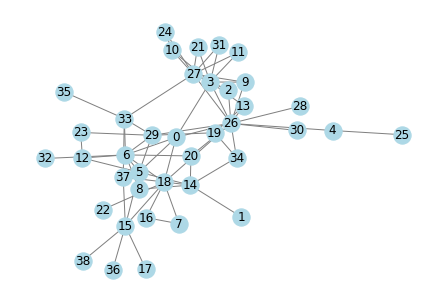

In [112]:
nx.draw(nx_graphs[0], with_labels=True, node_color="lightblue", edge_color="gray")
plt.show()

In [119]:
# Transforms list of NetworkX graphs into a list of GraKeL graphs
graphs = graph_from_networkx(nx_graphs, node_labels_tag='label')

In [120]:
# Step 3: Extract features using the Weisfeiler-Lehman graph kernel
wl_kernel = WeisfeilerLehman(n_iter=3)
X_wl = wl_kernel.fit_transform(graphs)

In [124]:
# Step 4: Train a machine learning model on the extracted features
X_train, X_test, y_train, y_test = train_test_split(X_wl, targets["target"], test_size=0.3, random_state=94)

In [126]:
# Step 5: Train and Test Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [127]:
# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification report: \n{report}")

Accuracy: 0.43333333333333335
Classification report: 
              precision    recall  f1-score   support

           0       0.39      0.39      0.39        28
           1       0.47      0.47      0.47        32

    accuracy                           0.43        60
   macro avg       0.43      0.43      0.43        60
weighted avg       0.43      0.43      0.43        60



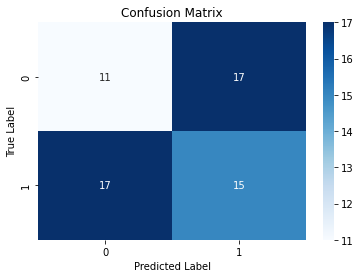

In [128]:
# Visualize classification report using seaborn
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()